# Data Preparation


In [ ]:
import os
import zipfile
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
from tqdm.notebook import tqdm as tq

In [ ]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /content/rockpaperscissors.zip

--2020-07-26 14:12:26--  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip
Resolving dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)... 52.239.197.36
Connecting to dicodingacademy.blob.core.windows.net (dicodingacademy.blob.core.windows.net)|52.239.197.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 322873683 (308M) [application/zip]
Saving to: ‘/content/rockpaperscissors.zip’

/content/rockpapers 100%[===================>] 307.92M  21.4MB/s    in 16s     

2020-07-26 14:12:42 (19.3 MB/s) - ‘/content/rockpaperscissors.zip’ saved [322873683/322873683]



In [ ]:
local_zip = '/content/rockpaperscissors.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
#membuang file readme agar tidak mempengaruhi pembagian tag dalam membuat dataset
os.remove('/content/rockpaperscissors/rps-cv-images/README_rpc-cv-images.txt')

In [ ]:
mypath= '/content/rockpaperscissors/rps-cv-images'
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [ ]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
paper       712
rock        726
scissors    750
dtype: int64

In [ ]:
df.head()

,path,file_name,tag
0,/content/rockpaperscissors/rps-cv-images/rock/...,uCt8rigwmrP07ZVr.png,rock
1,/content/rockpaperscissors/rps-cv-images/rock/...,nrRw9O00nT1ZeOJh.png,rock
2,/content/rockpaperscissors/rps-cv-images/rock/...,oky5NsS9ymRXKVf8.png,rock
3,/content/rockpaperscissors/rps-cv-images/rock/...,IcqtnpGHgStAPMXM.png,rock
4,/content/rockpaperscissors/rps-cv-images/rock/...,NQxWkhRHMkt2GrpB.png,rock


In [ ]:
x= df['path']
y= df['tag']

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x, y, train_size=0.6006, random_state=200)

In [ ]:
df_train = pd.DataFrame({'path':x_train
              ,'tag':y_train
             ,'set':'train'})

df_val = pd.DataFrame({'path':x_val
              ,'tag':y_val
             ,'set':'validation'})

In [ ]:
print('train size', len(df_train))
print('val size', len(df_val))

train size 1314
val size 874


In [ ]:
df_all = df_train.append(df_val).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(3)


set         tag     
train       paper       432
            rock        422
            scissors    460
validation  paper       280
            rock        304
            scissors    290
dtype: int64 




,path,tag,set
1887,/content/rockpaperscissors/rps-cv-images/sciss...,scissors,validation
1355,/content/rockpaperscissors/rps-cv-images/sciss...,scissors,validation
374,/content/rockpaperscissors/rps-cv-images/rock/...,rock,train


In [ ]:
datasource_path = mypath
dataset_path = "dataset/"

In [ ]:
for index, row in tq(df_all.iterrows()):
    
    #detect filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    #make folder destination dirs
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))
    
    #define file dest
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    #copy file from source to dest
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

# Data Modeling

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Sequential,constraints
from tensorflow.keras.models import Model

In [ ]:
dim = (100, 100)
channel = (3, )
input_shape = dim + channel
batch_size = 30
epoch = 10

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1. / 255, 
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

In [ ]:
train_generator = train_datagen.flow_from_directory('dataset/train/', 
                                                    target_size=dim, 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical', 
                                                    shuffle=True)
val_generator = val_datagen.flow_from_directory('dataset/validation/', 
                                                target_size=dim, 
                                                batch_size=batch_size, 
                                                class_mode='categorical', 
                                                shuffle=True)

num_class = val_generator.num_classes
labels = train_generator.class_indices.keys()

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [ ]:
print(labels)

dict_keys(['paper', 'rock', 'scissors'])


In [ ]:
def tf_data_generator(generator, input_shape):
    num_class = generator.num_classes
    tf_generator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None
                        , input_shape[0]
                        , input_shape[1]
                        , input_shape[2]]
                       ,[None, num_class])
    )
    return tf_generator

In [ ]:
train_data = tf_data_generator(train_generator, input_shape)
val_data = tf_data_generator(val_generator, input_shape)

In [ ]:
model = Sequential()
model.add(layers.Conv2D(128, (3, 3), padding='same', input_shape=input_shape))

model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_class))
model.add(layers.Activation('softmax'))

optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-5, momentum=0.7, nesterov=True)

#compile model
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 128)     3584      
_________________________________________________________________
activation (Activation)      (None, 100, 100, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 32)        36896     
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        1

# Model Training

In [ ]:
class schedulerCallback(tf.keras.callbacks.Callback):
  def scheduler(epoch):
    if epoch < 10:
      return 0.01
    else:
      return 0.01 * tf.math.exp(0.1 * (10 - epoch))

callbacks = schedulerCallback()

reduceROn = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.01)

In [ ]:
history = model.fit(x=train_data,
          steps_per_epoch=len(train_generator),
          epochs=epoch,
          validation_data=val_data,
          validation_steps=len(val_generator), 
          shuffle=True,
          callbacks=[callbacks,reduceROn],
          verbose = 1)

Epoch 1/10
44/44 [==============================] - 161s 4s/step - loss: 1.0885 - accuracy: 0.3912 - val_loss: 1.0429 - val_accuracy: 0.4622 - lr: 0.0100
Epoch 2/10
44/44 [==============================] - 160s 4s/step - loss: 0.9614 - accuracy: 0.5563 - val_loss: 0.7696 - val_accuracy: 0.7357 - lr: 0.0100
Epoch 3/10
44/44 [==============================] - 160s 4s/step - loss: 0.7403 - accuracy: 0.6903 - val_loss: 0.6303 - val_accuracy: 0.7529 - lr: 0.0100
Epoch 4/10
44/44 [==============================] - 164s 4s/step - loss: 0.6519 - accuracy: 0.7420 - val_loss: 0.5615 - val_accuracy: 0.7838 - lr: 0.0100
Epoch 5/10
44/44 [==============================] - 160s 4s/step - loss: 0.5870 - accuracy: 0.7686 - val_loss: 0.4899 - val_accuracy: 0.8227 - lr: 0.0100
Epoch 6/10
44/44 [==============================] - 160s 4s/step - loss: 0.5175 - accuracy: 0.7953 - val_loss: 0.4582 - val_accuracy: 0.8467 - lr: 0.0100
Epoch 7/10
44/44 [==============================] - 160s 4s/step - loss: 0.4

In [ ]:
history.history['loss']

[1.0884588956832886,
 0.9614038467407227,
 0.7402608394622803,
 0.6518737077713013,
 0.5869503617286682,
 0.5174919962882996,
 0.4598225951194763,
 0.43290209770202637,
 0.3728078603744507,
 0.3137660026550293]

In [ ]:
history.history['accuracy']

[0.39117199182510376,
 0.556316614151001,
 0.6902587413787842,
 0.7420091032981873,
 0.7686453461647034,
 0.7952815890312195,
 0.8082191944122314,
 0.8455098867416382,
 0.8584474921226501,
 0.8759512901306152]

# Model Evaluation

In [ ]:
loss, acc = model.evaluate(train_data,steps=len(train_generator),verbose=0)
print('Accuracy on training data: {:.4f} \nLoss on training data: {:.4f}'.format(acc,loss),'\n')

loss, acc = model.evaluate(val_data,steps=len(val_generator),verbose=0)
print('Accuracy on validation data: {:.4f} \nLoss on test data: {:.4f}'.format(acc,loss),'\n')

Accuracy on training data: 0.9239 
Loss on training data: 0.2069 

Accuracy on validation data: 0.9268 
Loss on test data: 0.2287 



# Model Loss and Accuracy Plot

In [ ]:
from matplotlib import pyplot as plt

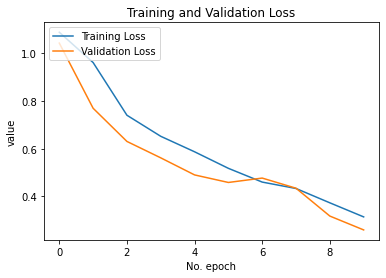

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

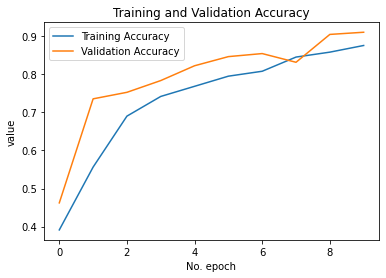

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# Image Prediction Function

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.image as mpimg

Using TensorFlow backend.


In [ ]:
%matplotlib inline

In [ ]:
input_size = (100,100)
channel = (3,)
input_shape = input_size + channel

Saving 2DdERUV7Te8ivywq.png to 2DdERUV7Te8ivywq.png
2DdERUV7Te8ivywq.png
Rock


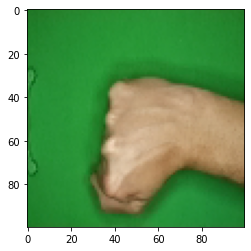

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=input_shape)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = model.predict(images, batch_size=batch_size)
  
  print(fn)
  if classes[0][0]==1:
    print('Paper')
  elif classes[0][1]==1:
    print('Rock')
  elif classes[0][2]==1:
    print('Scissor')
  else:
    print('Unindentified')